In [3]:
%%capture
#%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define some loading utilities

In [4]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None):
  model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

## Load the VQGANs

First, load (and optionally display) the model configs. Then, load the VQGAN models.

In [5]:
!ls dat/checkpoints

ls: cannot access 'dat/checkpoints': No such file or directory


In [6]:
config1024 = load_config("configs/imagenet_vqgan.yaml", display=False)

model1024 = load_vqgan(config1024, ckpt_path="logs/2021-07-16T20-09-54_imagenet_vqgan/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from logs/2021-07-15T09-47-33_imagenet_vqgan/checkpoints/last.ckpt


In [7]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

# font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf", 22)

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))


def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)


def reconstruct_with_dalle(x, encoder, decoder, do_preprocess=False):
  # takes in tensor (or optionally, a PIL image) and returns a PIL image
  if do_preprocess:
    x = preprocess(x)
  z_logits = encoder(x)
  z = torch.argmax(z_logits, axis=1)
  
  print(f"DALL-E: latent shape: {z.shape}")
  z = F.one_hot(z, num_classes=encoder.vocab_size).permute(0, 3, 1, 2).float()

  x_stats = decoder(z).float()
  x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
  x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

  return x_rec


def stack_reconstructions(input, x1, x2, x3, titles=[]):
  assert input.size == x1.size == x2.size == x3.size
  w, h = input.size[0], input.size[1]
  img = Image.new("RGB", (4*w, h))
  img.paste(input, (0,0))
  img.paste(x1, (1*w,0))
  img.paste(x2, (2*w,0))
  img.paste(x3, (3*w,0))
  for i, title in enumerate(titles):
    ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255), font=font) # coordinates, text, color, font
  return img

Load the provided encoder and decoder.

## Reconstruct some images

Define the reconstruction pipeline and stack the reconstructions for a direct comparison.

In [8]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [75]:
import cv2

def reconstruction_pipeline(fn, size=512):
    im_orig = Image.open(fn)
    im_orig = Image.merge('RGB', (im_orig, im_orig, im_orig))
    im =Image.open(fn).resize((512,512))
    im = Image.merge('RGB', (im, im, im))
    print(im.size)
    x = preprocess(im, target_image_size=size)
    x = x.to(DEVICE)
    print(f"input is of size: {x.shape}")
    x2 = reconstruct_with_vqgan(preprocess_vqgan(x), model1024)
    img = get_concat_h(im_orig, custom_to_pil(x2[0]))
    return img

(512, 512)
input is of size: torch.Size([1, 3, 256, 256])
VQGAN: latent shape: torch.Size([16, 16])


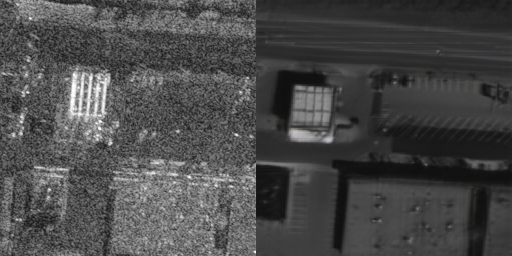

In [82]:
reconstruction_pipeline('/home/spencer/PycharmProjects/CycleGAN/CycleGAN/datasets/eo_sar_256_tiny/trainB/train/Gotcha221.png', size=256)


